# <font color='blue'>**@panData**</font>
# <font color='blue'>**Development and Deployment of Machine Learning Models**</font>

### <font color='blue'>**Predicting Customer Churn with RandomForest - From Problem Conception to Deployment**</font>


## **Python Packages Used in the Project**


In [1]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.9 MB/s eta 0:00:00


In [2]:
# Imports
import joblib
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Basic settings for the graphs
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [6, 5]

In [4]:
%reload_ext watermark
%watermark -a "@panData"

Author: @panData



## **Loading the Data**


In [5]:
import pandas as pd

# Load the dataset (
df = pd.read_csv('dataset.csv')

# Rename the columns
column_mapping = {
    'Idade': 'Age',
    'UsoMensal': 'MonthlyUsage',
    'Plano': 'Plan',
    'SatisfacaoCliente': 'CustomerSatisfaction',
    'TempoContrato': 'ContractDuration',
    'ValorMensal': 'MonthlyValue',
    'Churn': 'Churn'
}
df = df.rename(columns=column_mapping)

# Map the categorical values
plan_mapping = {
    'Premium': 'Premium',
    'Standard': 'Standard',
    'Basico': 'Basic'
}
df['Plan'] = df['Plan'].map(plan_mapping)

contract_duration_mapping = {
    'Curto': 'Short',
    'Medio': 'Medium',
    'Longo': 'Long'
}
df['ContractDuration'] = df['ContractDuration'].map(contract_duration_mapping)

# Save the translated dataset (replace 'translated_dataset.csv' with desired name)
df.to_csv('translated_dataset.csv', index=False)

print("Dataset successfully translated!")

Dataset successfully translated!


In [6]:
# Type of object
type(df)

pandas.core.frame.DataFrame

In [7]:
# Shape
df.shape

(1000, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1000 non-null   int64  
 1   MonthlyUsage          1000 non-null   int64  
 2   Plan                  1000 non-null   object 
 3   CustomerSatisfaction  1000 non-null   int64  
 4   ContractDuration      1000 non-null   object 
 5   MonthlyValue          1000 non-null   float64
 6   Churn                 1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


In [9]:
# Sample of the data
df.head()

,Age,MonthlyUsage,Plan,CustomerSatisfaction,ContractDuration,MonthlyValue,Churn
0,56,52,Premium,1,Short,75.48,0
1,69,65,Basic,4,Short,79.25,0
2,46,76,Standard,3,Long,183.56,0
3,32,42,Basic,2,Long,162.50,0
4,60,74,Standard,2,Long,186.23,1


## **Exploratory Analysis**


We define the target variable (the focus of the study).

Churn Variable:

- 1 --> Positive class (churn occurred, i.e., the subscription was canceled)
- 0 --> Negative class (no churn, i.e., the subscription was not canceled)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# EDA Function with Grid Plot
def eda(data):
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = data.select_dtypes(exclude=['int64', 'float64']).columns

    num_plots = len(numeric_columns) * 2 + len(categorical_columns) * 2
    rows = 3
    cols = 5

    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()

    plot_index = 0

    for column in numeric_columns:
        sns.histplot(data[column], kde=True, ax=axes[plot_index])
        axes[plot_index].set_title(f'Distribution of {column}', fontsize=14)
        plot_index += 1

        sns.boxplot(x='Churn', y=column, data=data, ax=axes[plot_index])
        axes[plot_index].set_title(f'{column} vs Churn', fontsize=14)
        plot_index += 1

    for column in categorical_columns:
        sns.countplot(x=column, data=data, ax=axes[plot_index])
        axes[plot_index].set_title(f'Distribution of {column}', fontsize=14)
        plot_index += 1

        sns.countplot(x=column, hue='Churn', data=data, ax=axes[plot_index])
        axes[plot_index].set_title(f'{column} vs Churn', fontsize=14)
        plot_index += 1

    while plot_index < len(axes):
        fig.delaxes(axes[plot_index])
        plot_index += 1

    plt.tight_layout()
    plt.show()

# Example usage with a sample DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv('your_dataset.csv')
# eda(df)



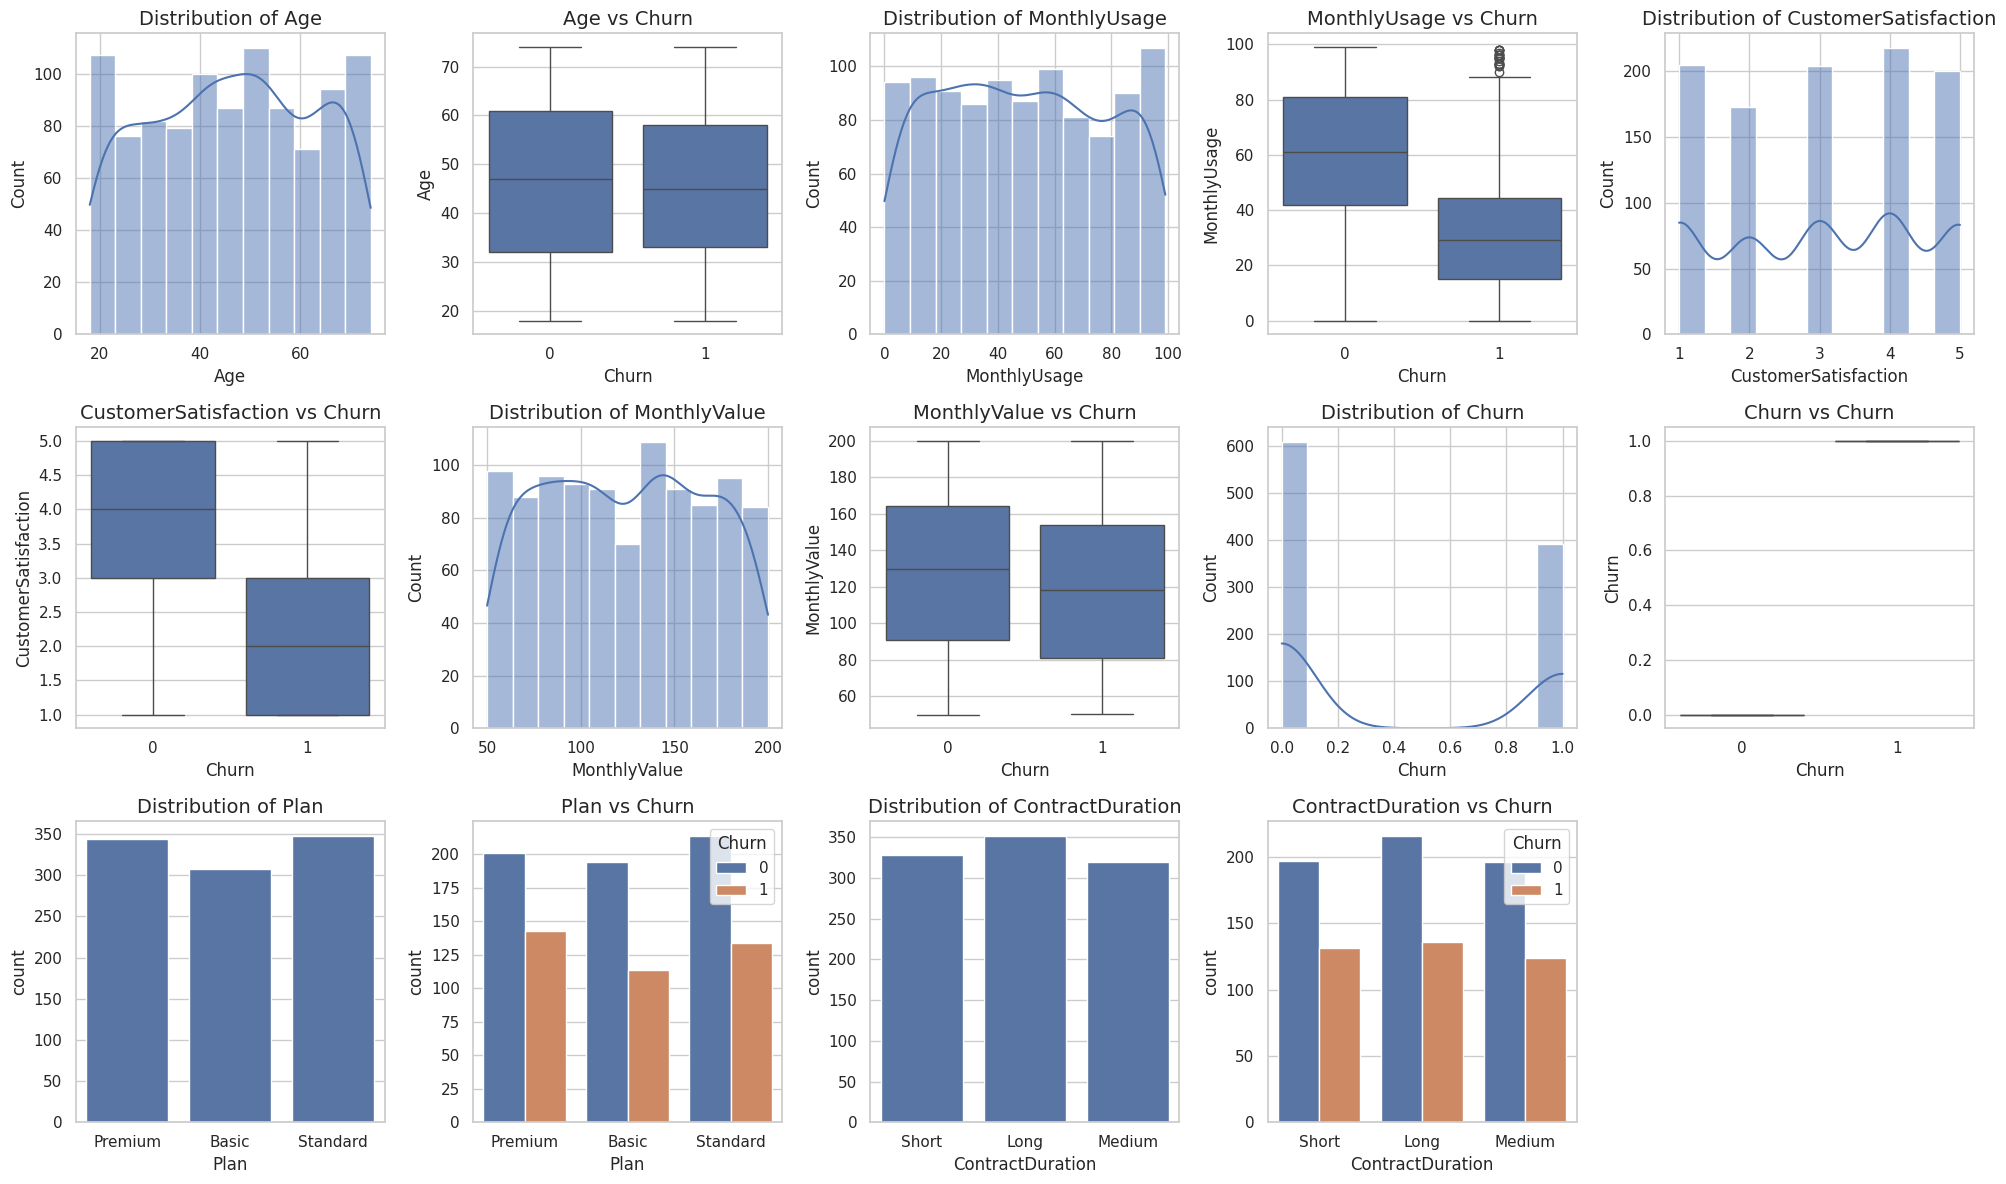

In [11]:
# Performing EDA
eda(df)

## **Automating the Train-Test Split Process**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1000 non-null   int64  
 1   MonthlyUsage          1000 non-null   int64  
 2   Plan                  1000 non-null   object 
 3   CustomerSatisfaction  1000 non-null   int64  
 4   ContractDuration      1000 non-null   object 
 5   MonthlyValue          1000 non-null   float64
 6   Churn                 1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


In [13]:
from sklearn.model_selection import train_test_split

# Optimized function to automate the train-test split
def split_dataset(data, target_column, test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    - data (DataFrame): The complete DataFrame.
    - target_column (str): The name of the target column.
    - test_size (float): The proportion of the test set (default is 0.2).
    - random_state (int): Seed for random number generation (default is 42).

    Returns:
    - X_train (DataFrame): Training set for the independent variables.
    - X_test (DataFrame): Testing set for the independent variables.
    - y_train (Series): Training set for the target variable.
    - y_test (Series): Testing set for the target variable.
    """

    # Split the dataset into features (X) and target (y)
    X = data.drop(columns=target_column)
    y = data[target_column]

    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test


In [14]:
# Using the previous function
test_size_value = 0.3
X_train, X_test, y_train, y_test = split_dataset(df, 'Churn', test_size=test_size_value)

In [15]:
# Checking the size of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 6), (300, 6), (700,), (300,))

## **Data Preprocessing**

Preprocessing, especially the application of encoding techniques and data normalization, should ideally be done after splitting the dataset into training and testing sets. This prevents information leakage from the test set into the training set, which can occur if preprocessing is done before the split.

In [16]:
# Sample of the data
df.head()

,Age,MonthlyUsage,Plan,CustomerSatisfaction,ContractDuration,MonthlyValue,Churn
0,56,52,Premium,1,Short,75.48,0
1,69,65,Basic,4,Short,79.25,0
2,46,76,Standard,3,Long,183.56,0
3,32,42,Basic,2,Long,162.50,0
4,60,74,Standard,2,Long,186.23,1


In [17]:
# Selecting categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns

In [18]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [19]:
categorical_cols

Index(['Plan', 'ContractDuration'], dtype='object')

### **One-Hot Encoding**

In [20]:
# Applying One-Hot Encoding separately to the training and testing sets
encoder = OneHotEncoder(sparse_output=False)

By default, OneHotEncoder returns a sparse matrix when you use it to transform data. A sparse matrix is an efficient way to store data with many zeros (missing values). However, if you set sparse_output=False, the encoder will return a dense matrix (numpy array) instead of a sparse matrix. A dense matrix is easier to work with and understand but can consume more memory if the data is large and most values are zero.


In [21]:
# Training the encoder with the training set and transforming both training and testing sets
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

In [22]:
# Renaming the columns to match the category names
X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

In [23]:
# Removing the original categorical columns and adding the encoded ones
X_train_preprocessed = X_train.drop(categorical_cols, axis=1).reset_index(drop=True)
X_train_preprocessed = pd.concat([X_train_preprocessed, X_train_encoded], axis=1)

In [24]:
X_train_preprocessed.head()

,Age,MonthlyUsage,CustomerSatisfaction,MonthlyValue,Plan_Basic,Plan_Premium,Plan_Standard,ContractDuration_Long,ContractDuration_Medium,ContractDuration_Short
0,65,80,4,174.10,0.0,0.0,1.0,0.0,1.0,0.0
1,49,18,3,101.59,1.0,0.0,0.0,1.0,0.0,0.0
2,19,91,4,87.93,1.0,0.0,0.0,0.0,1.0,0.0
3,52,0,1,90.74,0.0,0.0,1.0,1.0,0.0,0.0
4,62,60,1,134.59,1.0,0.0,0.0,0.0,0.0,1.0


Any transformation applied to the training data must also be applied to the testing data and to any new data.


In [25]:
# Removing the original categorical columns and adding the encoded ones
X_test_preprocessed = X_test.drop(categorical_cols, axis=1).reset_index(drop=True)
X_test_preprocessed = pd.concat([X_test_preprocessed, X_test_encoded], axis=1)

In [26]:
# Viewing the first few rows of the training and testing datasets after preprocessing
X_train_preprocessed.head()

,Age,MonthlyUsage,CustomerSatisfaction,MonthlyValue,Plan_Basic,Plan_Premium,Plan_Standard,ContractDuration_Long,ContractDuration_Medium,ContractDuration_Short
0,65,80,4,174.10,0.0,0.0,1.0,0.0,1.0,0.0
1,49,18,3,101.59,1.0,0.0,0.0,1.0,0.0,0.0
2,19,91,4,87.93,1.0,0.0,0.0,0.0,1.0,0.0
3,52,0,1,90.74,0.0,0.0,1.0,1.0,0.0,0.0
4,62,60,1,134.59,1.0,0.0,0.0,0.0,0.0,1.0


In [27]:
X_test_preprocessed.head()

,Age,MonthlyUsage,CustomerSatisfaction,MonthlyValue,Plan_Basic,Plan_Premium,Plan_Standard,ContractDuration_Long,ContractDuration_Medium,ContractDuration_Short
0,36,86,3,190.77,0.0,0.0,1.0,0.0,1.0,0.0
1,61,31,4,177.03,1.0,0.0,0.0,0.0,1.0,0.0
2,24,38,2,139.14,1.0,0.0,0.0,0.0,0.0,1.0
3,26,94,4,162.87,0.0,0.0,1.0,0.0,0.0,1.0
4,70,70,1,58.34,0.0,1.0,0.0,0.0,0.0,1.0


## **StandardScaler**

In [28]:
# Numeric variables
numeric_cols = X_train_preprocessed.select_dtypes(include=['int64', 'float64']).columns

In [29]:
# Creating the StandardScaler
scaler = StandardScaler()

In [30]:
# Applying the StandardScaler to the numeric variables
X_train_preprocessed[numeric_cols] = scaler.fit_transform(X_train_preprocessed[numeric_cols])
X_test_preprocessed[numeric_cols] = scaler.transform(X_test_preprocessed[numeric_cols])

In [31]:
# Viewing the first few rows of the training and testing datasets after preprocessing
X_train_preprocessed.head()

,Age,MonthlyUsage,CustomerSatisfaction,MonthlyValue,Plan_Basic,Plan_Premium,Plan_Standard,ContractDuration_Long,ContractDuration_Medium,ContractDuration_Short
0,1.180292,1.069020,0.676895,1.130872,-0.668043,-0.720027,1.362770,-0.729197,1.415730,-0.685994
1,0.178225,-1.055509,-0.029255,-0.544723,1.496910,-0.720027,-0.733799,1.371371,-0.706349,-0.685994
2,-1.700652,1.445952,0.676895,-0.860385,1.496910,-0.720027,-0.733799,-0.729197,1.415730,-0.685994
3,0.366112,-1.672308,-1.441554,-0.795450,-0.668043,-0.720027,1.362770,1.371371,-0.706349,-0.685994
4,0.992405,0.383688,-1.441554,0.217856,1.496910,-0.720027,-0.733799,-0.729197,-0.706349,1.457738


In [32]:
X_test_preprocessed.head()

,Age,MonthlyUsage,CustomerSatisfaction,MonthlyValue,Plan_Basic,Plan_Premium,Plan_Standard,ContractDuration_Long,ContractDuration_Medium,ContractDuration_Short
0,-0.635955,1.274619,-0.029255,1.516090,-0.668043,-0.720027,1.362770,-0.729197,1.415730,-0.685994
1,0.929775,-0.610043,0.676895,1.198580,1.496910,-0.720027,-0.733799,-0.729197,1.415730,-0.685994
2,-1.387505,-0.370177,-0.735404,0.323000,1.496910,-0.720027,-0.733799,-0.729197,-0.706349,1.457738
3,-1.262247,1.548752,0.676895,0.871364,-0.668043,-0.720027,1.362770,-0.729197,-0.706349,1.457738
4,1.493438,0.726354,-1.441554,-1.544164,-0.668043,1.388838,-0.733799,-0.729197,-0.706349,1.457738


## **Modeling**

In [33]:
# Creating the RandomForest model
model_v1 = RandomForestClassifier(random_state=42)

In [34]:
# Training the model
model_v1.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Making predictions on the test set
y_pred = model_v1.predict(X_test_preprocessed)

In [36]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [37]:
accuracy

0.7866666666666666

In [38]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       182
           1       0.72      0.75      0.73       118

    accuracy                           0.79       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.79      0.79       300



## **Cross-Validation**


In [39]:
# Creating a new RandomForest model for cross-validation
model_cv = RandomForestClassifier(random_state=42)

In [40]:
# Performing cross-validation
# We will use 5 folds for cross-validation
cv_scores = cross_val_score(model_cv, X_train_preprocessed, y_train, cv=5)


In [41]:
cv_scores

array([0.78571429, 0.78571429, 0.77142857, 0.72857143, 0.69285714])

These results provide a more robust view of the model's performance, as cross-validation evaluates the model's ability to generalize to new data. The variation in accuracy scores across different folds indicates that the model may behave inconsistently on different subsets of the data. This could be due to data characteristics, such as class imbalance, or the need for finer tuning of the model's hyperparameters.


## **Hyperparameter Optimization**


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [42]:
# Defining the hyperparameters to be optimized
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum tree depth
    'min_samples_split': [2, 4, 6],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at a leaf node
}

In [43]:
# Creating the RandomForest model for optimization
model_opt = RandomForestClassifier(random_state=42)

In [44]:
# Setting up the grid search with cross-validation
grid_search = GridSearchCV(model_opt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [45]:
# Performing the optimization with the training set
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [46]:
# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [47]:
best_params, best_score

({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 0.7642857142857143)

## **Final Version of the Model**


In [48]:
# Creating the RandomForest model with the best hyperparameters
final_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                      max_depth=best_params['max_depth'],
                                      min_samples_split=best_params['min_samples_split'],
                                      min_samples_leaf=best_params['min_samples_leaf'],
                                      random_state=42)

In [49]:
# Training the final model with the training set
final_model.fit(X_train_preprocessed, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [50]:
# Predictions using test data
y_pred_final = final_model.predict(X_test_preprocessed)

In [51]:
# Evaluating the final model on the test set
final_accuracy = accuracy_score(y_test, y_pred_final)
final_classification_report = classification_report(y_test, y_pred_final)

In [52]:
final_accuracy

0.7933333333333333

In [53]:
print(final_classification_report)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       182
           1       0.73      0.75      0.74       118

    accuracy                           0.79       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.79      0.79       300



In [54]:
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [55]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [56]:
X_train_preprocessed.head()

,Age,MonthlyUsage,CustomerSatisfaction,MonthlyValue,Plan_Basic,Plan_Premium,Plan_Standard,ContractDuration_Long,ContractDuration_Medium,ContractDuration_Short
0,1.180292,1.069020,0.676895,1.130872,-0.668043,-0.720027,1.362770,-0.729197,1.415730,-0.685994
1,0.178225,-1.055509,-0.029255,-0.544723,1.496910,-0.720027,-0.733799,1.371371,-0.706349,-0.685994
2,-1.700652,1.445952,0.676895,-0.860385,1.496910,-0.720027,-0.733799,-0.729197,1.415730,-0.685994
3,0.366112,-1.672308,-1.441554,-0.795450,-0.668043,-0.720027,1.362770,1.371371,-0.706349,-0.685994
4,0.992405,0.383688,-1.441554,0.217856,1.496910,-0.720027,-0.733799,-0.729197,-0.706349,1.457738


In [57]:
%watermark -a "@panData "

Author: @panData 



In [58]:
#%watermark -v -m

In [59]:
#%watermark --iversions